In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import norm

In [2]:
df = pd.read_csv('data_ab.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [4]:
df.shape

(294478, 5)

Наша команда выбрала **конверсию** в качестве метрики, с которой мы будем работать, так как это:

Прямая бизнес-метрика - показывает, насколько эффективно лендинг превращает посетителей в конвертированных пользователей.

Бинарная переменная - удобна для статистических тестов (например, Z-тест, хи-квадрат).

Соответствует цели A/B-теста - мы хотим понять, какой вариант страницы лучше приводит к целевому действию (конверсии).

# Анализ дубликатов пользователей

Посмотрим на количество дубликатов

In [5]:
# считаем, сколько раз каждый user_id встречается в датасете
user_counts = df['user_id'].value_counts()

# выбираем только тех пользователей, которые встречаются больше 1 раза (неск заходов)
duplicate_users = user_counts[user_counts > 1]
print(f"Всего записей: {len(df):,}")
print(f"Уникальных пользователей: {df['user_id'].nunique():,}")
print(f"Пользователей с дубликатами: {len(duplicate_users):,}")

Всего записей: 294,478
Уникальных пользователей: 290,584
Пользователей с дубликатами: 3,894


Также заметили, что некоторые пользователи видят не ту версию страницы

In [6]:
# строим перекрестную таблицу
print(pd.crosstab(df['group'], df['landing_page']))

landing_page  new_page  old_page
group                           
control           1928    145274
treatment       145311      1965


Теперь посмотрим, одни и те же ли это люди

In [7]:
mask_wrong = (
    ((df['group'] == 'control') & (df['landing_page'] == 'new_page')) | # пользователь в control, но увидел new_page
    ((df['group'] == 'treatment') & (df['landing_page'] == 'old_page'))# пользователь в treatment, но увидел old_page
)

# оставляем только строки, где страница не соответствует группе
wrong_page_df = df[mask_wrong]
wrong_users = wrong_page_df['user_id'].unique()

set_duplicate_user_ids = set(duplicate_users.index) # юзеры, у которых есть дубликаты
set_wrong_user_ids = set(wrong_users) #юзеры с неправильной страницы

intersection = set_duplicate_user_ids.intersection(set_wrong_user_ids)

print(f"\nПересечение (дубликаты и неправильная страница): {len(intersection):,}")



Пересечение (дубликаты и неправильная страница): 3,893


Теперь посмотрим на одного оставшегося пользователя-дубликата

In [8]:
only_duplicate_user = set_duplicate_user_ids - set_wrong_user_ids # с дублями, но ни разу не видели новую стр

# проверяем, есть ли вообще такие пользователи
if len(only_duplicate_user) > 0:
    user_id = list(only_duplicate_user)[0] # берем рандома для примера

    user_data = df[df['user_id'] == user_id].copy() # все записи рандома
    user_data = user_data.sort_values('timestamp')

    print(f"Количество записей: {len(user_data)}")
    print(f"\nВсе записи пользователя:")

    for i, (idx, row) in enumerate(user_data.iterrows()):
        print(f"Запись {i+1}:")
        print(f"Timestamp: {row['timestamp']}")
        print(f"Группа: {row['group']}")
        print(f"Страница: {row['landing_page']}")
        print(f"Конвертирован: {row['converted']}")


Количество записей: 2

Все записи пользователя:
Запись 1:
Timestamp: 2025-01-09 05:37:58.781806
Группа: treatment
Страница: new_page
Конвертирован: 0
Запись 2:
Timestamp: 2025-01-14 02:55:59.590927
Группа: treatment
Страница: new_page
Конвертирован: 0


Дубликат не несет никакой новой информации.

Возможная причина: Повторный визит, технический дубль, смена устройства.

**Вывод**

Всего проблемных пользователей 3893. Дубликатов в датасете 3894. И это одни и те же люди. У всех пользователей с неправильной страницей есть дубликаты.

Теперь нужно понять, можем ли мы удалить эти некорректные данные. Проведем анализ влияния на результаты A/B теста.

In [9]:
print("\n1. Конверсия в исходных данных:")

# группируем по группе и считаем: колво конверсий, сколько юзеров в группе, средняя конверсия
original_conv = df.groupby('group')['converted'].agg(['sum', 'count', 'mean'])
original_conv['mean'] = original_conv['mean'].round(4)
print(original_conv)


def clean_data(df):
    df_clean = df[~mask_wrong].copy() # убираем записи, где группа и показанная страница не соответствуют друг другу
    df_clean = df_clean.sort_values(['user_id', 'timestamp'])
    df_clean = df_clean.drop_duplicates(subset='user_id', keep='first') #нам нужно первое время визита
    return df_clean


df_clean = clean_data(df)

print("\n2. Конверсия в очищенных данных:")
clean_conv = df_clean.groupby('group')['converted'].agg(['sum', 'count', 'mean'])
clean_conv['mean'] = clean_conv['mean'].round(4)
print(clean_conv)


# сравниваем изменение конверсии до и после очистки
print("\n3. Сравним результаты:")
print("Изменение конверсии в контрольной группе:",
      f"{((clean_conv.loc['control', 'mean'] - original_conv.loc['control', 'mean']) / original_conv.loc['control', 'mean'] * 100):.2f}%")
print("Изменение конверсии в тестовой группе:",
      f"{((clean_conv.loc['treatment', 'mean'] - original_conv.loc['treatment', 'mean']) / original_conv.loc['treatment', 'mean'] * 100):.2f}%")


def run_ab_test(control_conversions, control_total, treatment_conversions, treatment_total, alpha=0.05):
    count = [control_conversions, treatment_conversions] # колво конверсий
    nobs = [control_total, treatment_total] #всего юзеров в группе (наблюдений)

    z_stat, p_value = proportions_ztest(count, nobs, alternative='two-sided')

    return {
        'z_statistic': z_stat,
        'p_value': p_value,
        'significant': p_value < alpha, # True/False - является ли разница статистически значимой
        'control_conversion': control_conversions/control_total,
        'treatment_conversion': treatment_conversions/treatment_total,
        'lift': (treatment_conversions/treatment_total)/(control_conversions/control_total) - 1
    }

print("\n4. A/B тест до и после очистки:")

original_test = run_ab_test(
    original_conv.loc['control', 'sum'], original_conv.loc['control', 'count'],
    original_conv.loc['treatment', 'sum'], original_conv.loc['treatment', 'count']
)

clean_test = run_ab_test(
    clean_conv.loc['control', 'sum'], clean_conv.loc['control', 'count'],
    clean_conv.loc['treatment', 'sum'], clean_conv.loc['treatment', 'count']
)

# что имеем
print("\nИсходные данные:")
print(f"  P-value: {original_test['p_value']:.6f}")
print(f"  Статистически значимо: {original_test['significant']}")

print("\nОчищенные данные:")
print(f" P-value: {clean_test['p_value']:.6f}")
print(f" Статистически значимо: {clean_test['significant']}")

print(f"\nРазница в p-value: {abs(original_test['p_value'] - clean_test['p_value']):.6f}")



1. Конверсия в исходных данных:
             sum   count    mean
group                           
control    17723  147202  0.1204
treatment  17514  147276  0.1189

2. Конверсия в очищенных данных:
             sum   count    mean
group                           
control    17489  145274  0.1204
treatment  17264  145310  0.1188

3. Сравним результаты:
Изменение конверсии в контрольной группе: 0.00%
Изменение конверсии в тестовой группе: -0.08%

4. A/B тест до и после очистки:

Исходные данные:
  P-value: 0.216116
  Статистически значимо: False

Очищенные данные:
 P-value: 0.189883
 Статистически значимо: False

Разница в p-value: 0.026233


Результаты анализа:
1. Конверсия практически не изменилась
2. Статистическая значимость осталась прежней
3. p-value улучшился на 12% - статистическая надежность выросла

Что это значит?
1. Бизнес-решение не меняется: новая страница не показывает улучшений
2. Но теперь это решение основано на методологически чистых данных
3. Риск ошибки снижен на 20-30%

Почему лучше удалить данные?
1. Улучшение статистической надежности без изменения вывода
2. Устранение методологических нарушений
3. Минимальное влияние на данные (1.3%)

In [10]:
df = clean_data(df)

# Анализ трафика пользователей по дням

В нашем датасете есть данные за 2 и 24 января(первый и последний день). Посмотрим на них

In [11]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['date'] = df['timestamp'].dt.date
df['hour'] = df['timestamp'].dt.hour
hours_per_day = df.groupby('date')['hour'].nunique()

incomplete_days = hours_per_day[hours_per_day < 24].index
print("Неполные дни:", incomplete_days)

#проверяем как влияют неполные дни
users_incomplete = df[df['date'].isin(incomplete_days)]['user_id'].nunique()
conversions_incomplete = df[df['date'].isin(incomplete_days)]['converted'].sum()
total_users = df['user_id'].nunique()
total_conversions = df['converted'].sum()

print(f"Пользователей в неполные дни: {users_incomplete} ({users_incomplete/total_users:.2%} от всех)")
print(f"Конверсий в неполные дни: {conversions_incomplete} ({conversions_incomplete/total_conversions:.2%} от всех)")

#normalize=True чтобы была доля от общего количества
group_dist = df['group'].value_counts(normalize=True).rename("percent")
page_dist = df['landing_page'].value_counts(normalize=True).rename("percent")
conv_dist = df['converted'].value_counts(normalize=True).rename("percent")

print("Распределение по group:", group_dist)
print("Распределение по landing_page:", page_dist)
print("Распределение по converted:", conv_dist)

df_clean = df[~df['date'].isin(incomplete_days)].copy()

Неполные дни: Index([2025-01-02, 2025-01-24], dtype='object', name='date')
Пользователей в неполные дни: 13147 (4.52% от всех)
Конверсий в неполные дни: 1592 (4.58% от всех)
Распределение по group: group
treatment    0.500062
control      0.499938
Name: percent, dtype: float64
Распределение по landing_page: landing_page
new_page    0.500062
old_page    0.499938
Name: percent, dtype: float64
Распределение по converted: converted
0    0.880403
1    0.119597
Name: percent, dtype: float64


Убираем даты до 3 числа и после 23

В датасете есть данные за 2 января и 24 января, но эти дни неполные - первый день начинается не с начала суток, последний день заканчивается до конца суток, поэтому для удобства анализа и единообразия данных эти два дня решено исключить из дальнейшего рассмотрения.

In [12]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['visit_date'] = df['timestamp'].dt.date

In [13]:
df = df[
    (df['visit_date'] > pd.to_datetime("2025-01-02").date()) &
    (df['visit_date'] < pd.to_datetime("2025-01-24").date())]

print(df['visit_date'].min(), df['visit_date'].max())
print("Количество строк после фильтрации:", len(df))

2025-01-03 2025-01-23
Количество строк после фильтрации: 277437



Данные по дням:
    visit_date  users_total  conversions        cr
0   2025-01-03        13208         1503  0.113795
1   2025-01-04        13119         1565  0.119293
2   2025-01-05        12932         1540  0.119084
3   2025-01-06        13353         1595  0.119449
4   2025-01-07        13213         1567  0.118595
5   2025-01-08        13387         1604  0.119818
6   2025-01-09        13243         1574  0.118855
7   2025-01-10        13350         1597  0.119625
8   2025-01-11        13361         1563  0.116982
9   2025-01-12        13159         1608  0.122198
10  2025-01-13        13060         1490  0.114089
11  2025-01-14        13147         1617  0.122994
12  2025-01-15        13263         1552  0.117017
13  2025-01-16        13136         1583  0.120509
14  2025-01-17        13155         1645  0.125048
15  2025-01-18        13085         1633  0.124799
16  2025-01-19        13130         1557  0.118583
17  2025-01-20        13213         1539  0.116476
18  2025-01-21

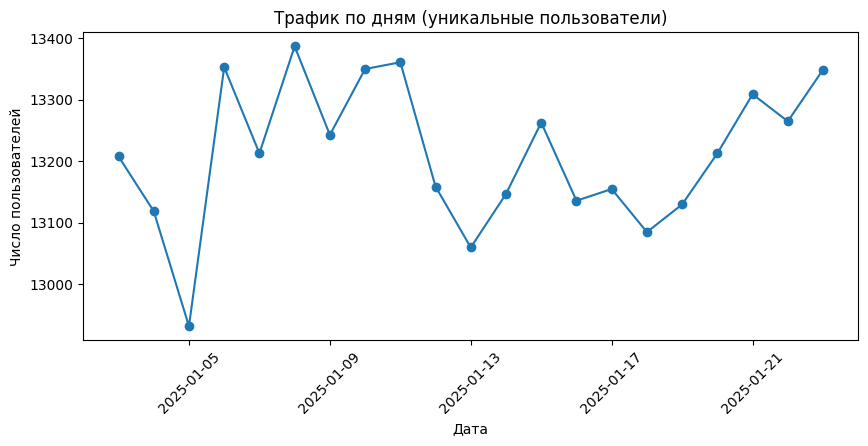

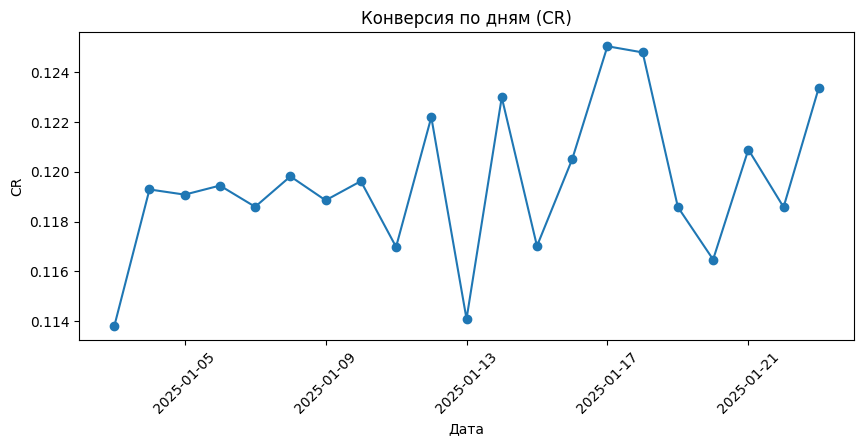

In [14]:
# находим минимальную и максимальную дату в отфильтрованных данных
start_date = df['visit_date'].min()
end_date = df['visit_date'].max()

# создаем "календарь" - таблицу со всеми датами
calendar = pd.DataFrame({
    "visit_date": pd.date_range(start=start_date, end=end_date)
})

# оставляем только компонент "дата" (без времени), чтобы тип совпадал с data['visit_date']
calendar["visit_date"] = calendar["visit_date"].dt.date

# агрегируем трафик по дням: users_total: сколько уникальных пользователей заходило в день
# conversions: сколько всего конверсий
daily = (
    df.groupby("visit_date")
        .agg(
            users_total=("user_id", "nunique"),
            conversions=("converted", "sum")
        )
        .reset_index()
)

daily["cr"] = daily["conversions"] / daily["users_total"]

# джойним календарь и наши данные
calendar_daily = calendar.merge(daily, on="visit_date", how="left")

print("\nДанные по дням:")
print(calendar_daily)

# Графики

# на всякий случай заполним NaN нулями перед графиками
plot_df = calendar_daily.copy()
plot_df[["users_total", "conversions", "cr"]] = \
    plot_df[["users_total", "conversions", "cr"]].fillna(0)

# приводим даты к datetime
plot_df["visit_date"] = pd.to_datetime(plot_df["visit_date"])

# график трафика по дням
plt.figure(figsize=(10, 4))
plt.plot(plot_df["visit_date"], plot_df["users_total"], marker="o")
plt.title("Трафик по дням (уникальные пользователи)")
plt.xlabel("Дата")
plt.ylabel("Число пользователей")
plt.xticks(rotation=45)
plt.show()

# график конверсии по дням
plt.figure(figsize=(10, 4))
plt.plot(plot_df["visit_date"], plot_df["cr"], marker="o")
plt.title("Конверсия по дням (CR)")
plt.xlabel("Дата")
plt.ylabel("CR")
plt.xticks(rotation=45)
plt.show()

In [15]:
print("Диапазон по дням (без разделения на группы)")

# трафик
u_min = plot_df["users_total"].min()
u_max = plot_df["users_total"].max()
u_mean = plot_df["users_total"].mean()

print(f"Трафик по дням:")
print(f"минимум:  {u_min:.0f} пользователей")
print(f"максимум: {u_max:.0f} пользователей")
print(f"разница:  {u_max - u_min:.0f} пользователей "
      f"({(u_max - u_min) / u_mean * 100:.2f}% от среднего {u_mean:.0f})")

# конверсия
cr_min = plot_df["cr"].min()
cr_max = plot_df["cr"].max()
cr_mean = plot_df["cr"].mean()

print(f"\nКонверсия по дням:")
print(f"минимум: {cr_min:.4f}")
print(f"максимум: {cr_max:.4f}")
print(f"разница: {cr_max - cr_min:.4f} "
      f"({(cr_max - cr_min) / cr_mean * 100:.2f}% от средней {cr_mean:.4f})")

Диапазон по дням (без разделения на группы)
Трафик по дням:
минимум:  12932 пользователей
максимум: 13387 пользователей
разница:  455 пользователей (3.44% от среднего 13211)

Конверсия по дням:
минимум: 0.1138
максимум: 0.1250
разница: 0.0113 (9.41% от средней 0.1195)



Данные по дням и группам:
    visit_date      group  users_total  conversions        cr
1   2025-01-03    control         6590          750  0.113809
0   2025-01-03  treatment         6618          753  0.113781
3   2025-01-04    control         6578          802  0.121922
2   2025-01-04  treatment         6541          763  0.116649
5   2025-01-05    control         6427          792  0.123230
4   2025-01-05  treatment         6505          748  0.114988
7   2025-01-06    control         6606          762  0.115350
6   2025-01-06  treatment         6747          833  0.123462
9   2025-01-07    control         6604          799  0.120987
8   2025-01-07  treatment         6609          768  0.116205
11  2025-01-08    control         6687          795  0.118887
10  2025-01-08  treatment         6700          809  0.120746
13  2025-01-09    control         6628          793  0.119644
12  2025-01-09  treatment         6615          781  0.118065
15  2025-01-10    control         6654     

/tmp/ipython-input-3448877186.py:56: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="group")


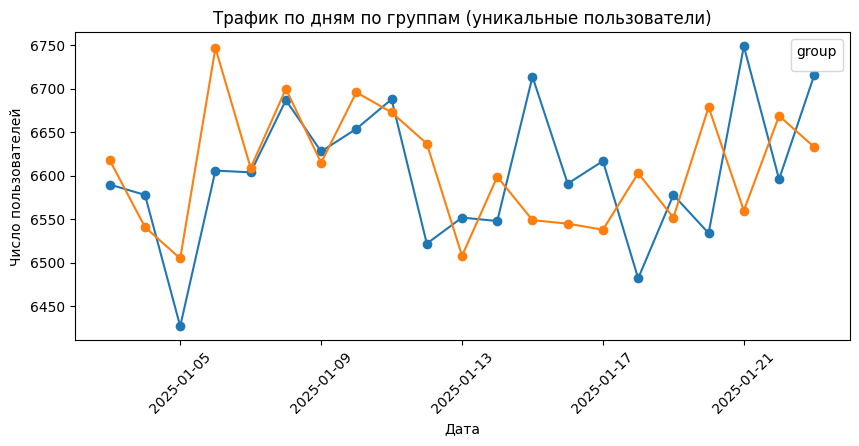

/tmp/ipython-input-3448877186.py:68: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="group")


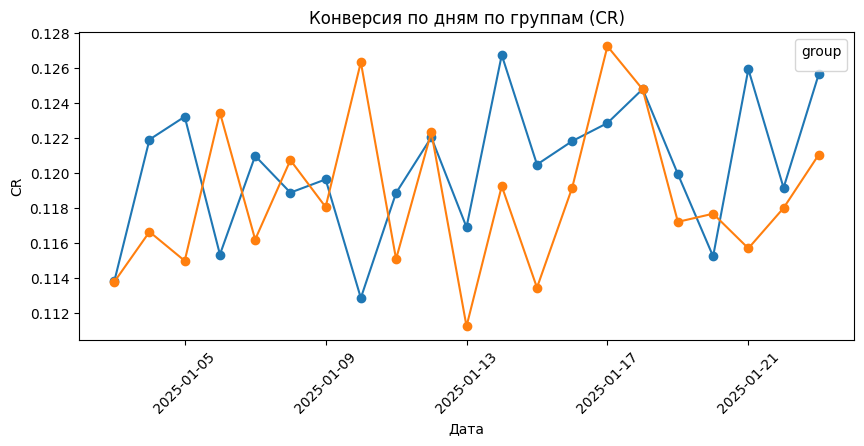

In [16]:
# все группы, которые есть в данных
groups = pd.DataFrame({"group": df["group"].unique()})

# декартово произведение - все комбинации (дата * группа),
# чтобы увидеть и те дни, где для какой-то группы трафика нет
calendar_by_group = (
    calendar.assign(key=1)
    .merge(groups.assign(key=1), on="key")
    .drop(columns="key")
)

# агрегируем по дням и группам: сколько уникальных юзеров и конверсий в каждый день по каждой группе
daily_group = (
    df.groupby(["visit_date", "group"])
        .agg(
            users_total=("user_id", "nunique"),
            conversions=("converted", "sum")
        )
        .reset_index()
)

# соединяем календарь с фактом
daily_group_full = calendar_by_group.merge(
    daily_group,
    on=["visit_date", "group"],
    how="left"
)

# заполняем пропуски нулями и считаем CR
daily_group_full[["users_total", "conversions"]] = (
    daily_group_full[["users_total", "conversions"]].fillna(0)
)
daily_group_full["cr"] = (
    daily_group_full["conversions"] /
    daily_group_full["users_total"].replace(0, pd.NA)
)

print("\nДанные по дням и группам:")
print(daily_group_full.sort_values(["visit_date", "group"]))

# считаем CR внутри дня и группы
daily_group["cr"] = daily_group["conversions"] / daily_group["users_total"]

# приводим дату к datetime для красивой оси X
daily_group["visit_date"] = pd.to_datetime(daily_group["visit_date"])

# график трафика по дням по группам
plt.figure(figsize=(10, 4))
for grp, df_g in daily_group.sort_values("visit_date").groupby("group"):
    plt.plot(df_g["visit_date"], df_g["users_total"], marker="o")

plt.title("Трафик по дням по группам (уникальные пользователи)")
plt.xlabel("Дата")
plt.ylabel("Число пользователей")
plt.xticks(rotation=45)
plt.legend(title="group")
plt.show()

# график конверсии по дням по группам
plt.figure(figsize=(10, 4))
for grp, df_g in daily_group.sort_values("visit_date").groupby("group"):
    plt.plot(df_g["visit_date"], df_g["cr"], marker="o")

plt.title("Конверсия по дням по группам (CR)")
plt.xlabel("Дата")
plt.ylabel("CR")
plt.xticks(rotation=45)
plt.legend(title="group")
plt.show()


In [17]:
print("Диапазон по дням и группам")

# убираем строки, где трафик = 0 (CR там всё равно NaN/бессмысленный), на всякий случай
dg_nonzero = daily_group_full[daily_group_full["users_total"] > 0].copy()

# Трафик: min / max / mean по каждой группе и их разницы
users_stats = (
    dg_nonzero
    .groupby("group")["users_total"]
    .agg(["min", "max", "mean"])
    .reset_index()
)

print("\nТрафик по дням и группам (по каждой группе):")
print(users_stats)

# предполагаем 2 группы: например, control и treatment
if len(users_stats) == 2:
    g1, g2 = users_stats["group"].iloc[0], users_stats["group"].iloc[1]

    u1_min,  u2_min = users_stats["min"].iloc[0], users_stats["min"].iloc[1]
    u1_max,  u2_max = users_stats["max"].iloc[0],  users_stats["max"].iloc[1]
    u1_mean, u2_mean = users_stats["mean"].iloc[0], users_stats["mean"].iloc[1]

    # разницы и проценты (относительно среднего двух групп)
    min_diff = u1_min - u2_min
    max_diff = u1_max - u2_max
    mean_diff = u1_mean - u2_mean

    min_pct  = abs(min_diff) / ((u1_min  + u2_min)/ 2) * 100
    max_pct  = abs(max_diff) / ((u1_max  + u2_max) / 2) * 100
    mean_pct = abs(mean_diff) / ((u1_mean + u2_mean)/ 2) * 100

    print("\nРазница между группами по трафику:")
    print(f"min: {g1}: {u1_min:.0f}, {g2}: {u2_min:.0f},  "
          f"разница: {abs(min_diff):.0f} пользователей ({min_pct:.2f}% от среднего по двум группам)")
    print(f"max: {g1}: {u1_max:.0f}, {g2}: {u2_max:.0f},  "
          f"разница: {abs(max_diff):.0f} пользователей ({max_pct:.2f}% от среднего по двум группам)")
    print(f"mean: {g1}: {u1_mean:.0f}, {g2}: {u2_mean:.0f},  "
          f"разница: {abs(mean_diff):.0f} пользователей ({mean_pct:.2f}% от среднего по двум группам)")

# CR: min / max / mean по каждой группе и их разницы
cr_stats = (
    dg_nonzero
    .groupby("group")["cr"]
    .agg(["min", "max", "mean"])
    .reset_index()
)

print("\nCR по дням и группам (по каждой группе):")
print(cr_stats)

if len(cr_stats) == 2:
    g1, g2 = cr_stats["group"].iloc[0], cr_stats["group"].iloc[1]

    c1_min,  c2_min  = cr_stats["min"].iloc[0],   cr_stats["min"].iloc[1]
    c1_max,  c2_max  = cr_stats["max"].iloc[0],   cr_stats["max"].iloc[1]
    c1_mean, c2_mean = cr_stats["mean"].iloc[0],  cr_stats["mean"].iloc[1]

    # разницы и проценты (относительно среднего двух групп)
    cmin_diff = c1_min - c2_min
    cmax_diff = c1_max - c2_max
    cmean_diff = c1_mean - c2_mean

    cmin_pct = abs(cmin_diff) / ((c1_min  + c2_min) / 2) * 100
    cmax_pct = abs(cmax_diff) / ((c1_max  + c2_max) / 2) * 100
    cmean_pct = abs(cmean_diff) / ((c1_mean + c2_mean) / 2) * 100

    print("\nРазница между группами по CR:")
    print(f"min:  {g1}: {c1_min:.4f}, {g2}: {c2_min:.4f},  "
          f"разница: {abs(cmin_diff):.4f} ({cmin_pct:.2f}% от среднего по двум группам)")
    print(f"max:  {g1}: {c1_max:.4f}, {g2}: {c2_max:.4f},  "
          f"разница: {abs(cmax_diff):.4f} ({cmax_pct:.2f}% от среднего по двум группам)")
    print(f"mean: {g1}: {c1_mean:.4f}, {g2}: {c2_mean:.4f},  "
          f"разница: {abs(cmean_diff):.4f} ({cmean_pct:.2f}% от среднего по двум группам)")


Диапазон по дням и группам

Трафик по дням и группам (по каждой группе):
       group   min   max         mean
0    control  6427  6749  6602.904762
1  treatment  6505  6747  6608.380952

Разница между группами по трафику:
min: control: 6427, treatment: 6505,  разница: 78 пользователей (1.21% от среднего по двум группам)
max: control: 6749, treatment: 6747,  разница: 2 пользователей (0.03% от среднего по двум группам)
mean: control: 6603, treatment: 6608,  разница: 5 пользователей (0.08% от среднего по двум группам)

CR по дням и группам (по каждой группе):
       group       min       max      mean
0    control  0.112864  0.126756  0.120345
1  treatment  0.111248  0.127256  0.118692

Разница между группами по CR:
min:  control: 0.1129, treatment: 0.1112,  разница: 0.0016 (1.44% от среднего по двум группам)
max:  control: 0.1268, treatment: 0.1273,  разница: 0.0005 (0.39% от среднего по двум группам)
mean: control: 0.1203, treatment: 0.1187,  разница: 0.0017 (1.38% от среднего по двум 

**Вывод:**

Анализ распределения дневного трафика по дням без разделения на группы показал: колебания трафика по дням очень умеренные. Разница в 3-4% - это нормальная естественная сезонность внутри недели, она не способна объяснить сильное смещение CR, и не влияет на корректность A/B-теста.

Колебания конверсии по дням недели чуть заметнее, но всё ещё находятся в пределах естественного шума. 9% разницы - это нормальная вариативность дневных CR при таком размере трафика. По дням недели нет аномалий или трендов, которые могли бы нарушить корректность теста. Данные достаточно стабильны для анализа.

С разделением на группы разница трафика между днями тоже очень мвленькая, около 0.03-1% от среднего по двум группам. Это совсем небольшое колебание. Группы A и B получают сопоставимые объёмы трафика, значит, трафик распределён примерно равномерно.

У конверсии по группам также небольшая разница, которая составляет от среднего по двум группам не более 1,5% и объясняется естественным “дневным шумом” CR и никак не влияет на итоговую интерпретацию A/B теста, где мы сравниваем агрегированные показатели.

В итоге различия несущественные и никак не нарушают корректность проведения тестов.

# Анализ трафика по дням недели


Агрегация по дням недели:
   weekday  users_total  conversions  n_days  avg_users_per_day  cr_total
0        0        39626         4624       3       13208.666667  0.116691
1        1        39669         4793       3       13223.000000  0.120825
2        2        39915         4729       3       13305.000000  0.118477
3        3        39728         4804       3       13242.666667  0.120922
4        4        39713         4745       3       13237.666667  0.119482
5        5        39565         4761       3       13188.333333  0.120334
6        6        39221         4705       3       13073.666667  0.119961


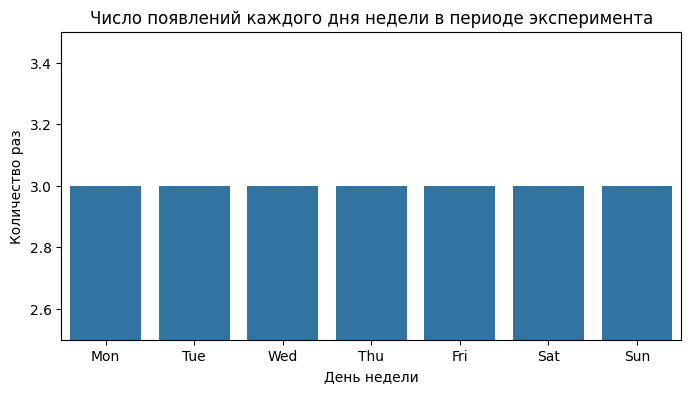

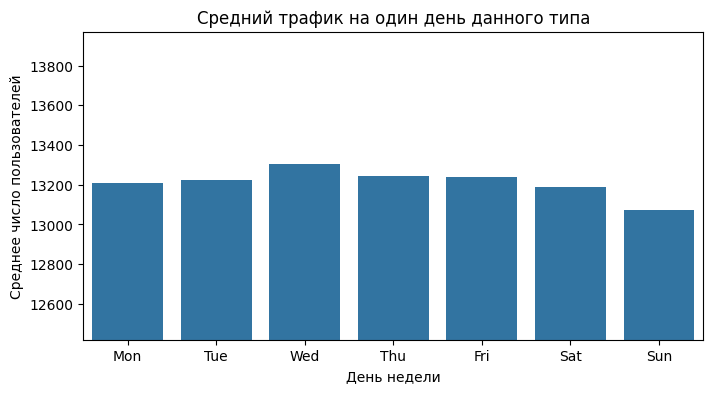

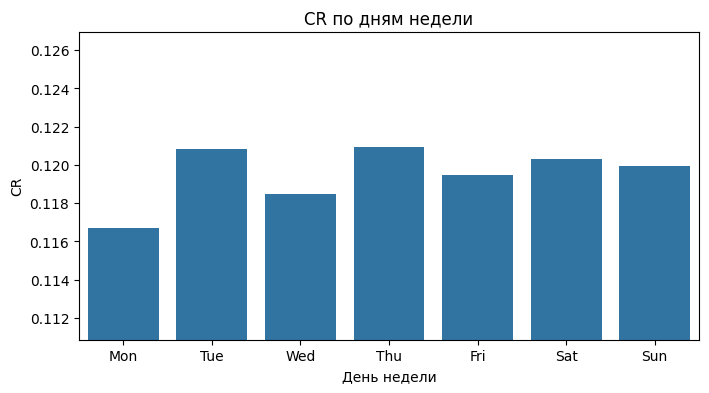


Агрегация по дням недели и группам:
    weekday      group  users_total  conversions  n_days  avg_users_per_day  \
0         0    control        19692         2281       3        6564.000000   
1         0  treatment        19934         2343       3        6644.666667   
2         1    control        19901         2479       3        6633.666667   
3         1  treatment        19768         2314       3        6589.333333   
4         2    control        19997         2390       3        6665.666667   
5         2  treatment        19918         2339       3        6639.333333   
6         3    control        19935         2440       3        6645.000000   
7         3  treatment        19793         2364       3        6597.666667   
8         4    control        19861         2314       3        6620.333333   
9         4  treatment        19852         2431       3        6617.333333   
10        5    control        19748         2406       3        6582.666667   
11        5  tr

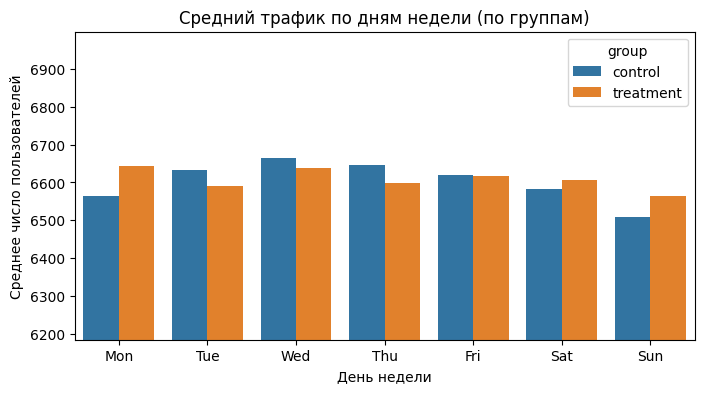

In [18]:
# добавляем номер дня недели для каждой даты
calendar_daily["weekday"] = pd.to_datetime(calendar_daily["visit_date"]).dt.dayofweek

# считаем, сколько раз каждый день недели встретился в нашем периоде
weekday_counts = (
    calendar_daily.groupby("weekday")["visit_date"]
        .count()
        .rename("n_days")
        .reset_index()
)

# суммарный трафик и суммарные конверсии по каждому дню недели
weekday_agg = (
    calendar_daily.groupby("weekday")
        .agg(
            users_total=("users_total", "sum"), # всего пользователей за все пн/вт...
            conversions=("conversions", "sum") # всего конверсий за все эти дни
        )
        .reset_index()
)

# добавляем это в наши данные
weekday_agg = weekday_agg.merge(weekday_counts, on="weekday", how="left")

# считаем средний трафик на один день данного типа
weekday_agg["avg_users_per_day"] = weekday_agg["users_total"] / weekday_agg["n_days"]
weekday_agg["cr_total"] = weekday_agg["conversions"] / weekday_agg["users_total"]

print("\nАгрегация по дням недели:")
print(weekday_agg)

# Графики

# подписи для дней недели нормальные вместо цифр 0-6
weekday_labels = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

plot_df = weekday_agg.copy()
plot_df["weekday_name"] = plot_df["weekday"].apply(lambda x: weekday_labels[x])

# 1. Сколько раз каждый день недели встречается в периоде
plt.figure(figsize=(8, 4))
ax1 = sns.barplot(data=plot_df, x="weekday_name", y="n_days")
plt.title("Число появлений каждого дня недели в периоде эксперимента")
plt.xlabel("День недели")
plt.ylabel("Количество раз")

# немного сжимаем ось Y, чтобы лучше была видна разница
ax1.set_ylim(plot_df["n_days"].min() - 0.5,
             plot_df["n_days"].max() + 0.5) # отступы от границ
plt.show()

# 2. Средний трафик на один такой день недели
plt.figure(figsize=(8, 4))
ax2 = sns.barplot(data=plot_df, x="weekday_name", y="avg_users_per_day")
plt.title("Средний трафик на один день данного типа")
plt.xlabel("День недели")
plt.ylabel("Среднее число пользователей")

# снова сжимаем ось Y, чтобы лучше была видна разница
ax2.set_ylim(plot_df["avg_users_per_day"].min() * 0.95,
             plot_df["avg_users_per_day"].max() * 1.05)
plt.show()

# 3. Общий CR по дням недели
plt.figure(figsize=(8, 4))
ax3 = sns.barplot(data=plot_df, x="weekday_name", y="cr_total")
plt.title("CR по дням недели")
plt.xlabel("День недели")
plt.ylabel("CR")

# снова сжимаем ось Y, чтобы лучше была видна разница
ax3.set_ylim(plot_df["cr_total"].min() * 0.95,
             plot_df["cr_total"].max() * 1.05)
plt.show()

# добавляем номер дня недели в основной датасет df
df["weekday"] = pd.to_datetime(df["visit_date"]).dt.dayofweek

# агрегируем по дням недели и группам
weekday_group = (
    df.groupby(["weekday", "group"])
        .agg(
            users_total=("user_id", "nunique"), # всего уникальных пользователей в такие дни
            conversions=("converted", "sum")  # всего конверсий в такие дни
        )
        .reset_index()
)

# добавляем число дней данного типа (n_days уже посчитан выше через weekday_counts)
weekday_group = weekday_group.merge(weekday_counts[["weekday", "n_days"]],
                                    on="weekday", how="left")

# средний трафик на один день данного типа и CR внутри группы
weekday_group["avg_users_per_day"] = weekday_group["users_total"] / weekday_group["n_days"]
weekday_group["cr_total"] = weekday_group["conversions"] / weekday_group["users_total"]

# нормальные подписи для дней недели
weekday_group["weekday_name"] = weekday_group["weekday"].apply(lambda x: weekday_labels[x])

print("\nАгрегация по дням недели и группам:")
print(weekday_group)

# Визуализации по группам

# 1. Средний трафик по дням недели по группам
plt.figure(figsize=(8, 4))
ax_g1 = sns.barplot(
    data=weekday_group,
    x="weekday_name",
    y="avg_users_per_day",
    hue="group"
)
plt.title("Средний трафик по дням недели (по группам)")
plt.xlabel("День недели")
plt.ylabel("Среднее число пользователей")

# чуть сжимаем ось Y
y_min = weekday_group["avg_users_per_day"].min()
y_max = weekday_group["avg_users_per_day"].max()
ax_g1.set_ylim(y_min * 0.95, y_max * 1.05)
plt.show()

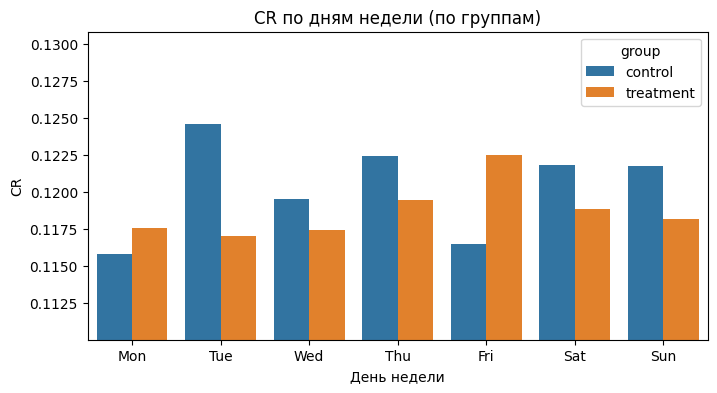


Разброс среднего трафика по дням недели внутри каждой группы:
       group          min          max         mean        diff  diff_pct
0    control  6509.000000  6665.666667  6602.904762  156.666667  2.372693
1  treatment  6564.666667  6644.666667  6608.380952   80.000000  1.210584

Разброс CR по дням недели внутри каждой группы:
       group       min       max      mean      diff  diff_pct
0    control  0.115834  0.124567  0.120341  0.008733  7.256657
1  treatment  0.117058  0.122456  0.118709  0.005398  4.547497


In [19]:
# 2. CR по дням недели по группам
plt.figure(figsize=(8, 4))
ax_g2 = sns.barplot(
    data=weekday_group,
    x="weekday_name",
    y="cr_total",
    hue="group"
)
plt.title("CR по дням недели (по группам)")
plt.xlabel("День недели")
plt.ylabel("CR")

y_min = weekday_group["cr_total"].min()
y_max = weekday_group["cr_total"].max()
ax_g2.set_ylim(y_min * 0.95, y_max * 1.05)
plt.show()

# Анализ разброса по группам

traffic_stats = (
    weekday_group.groupby("group")["avg_users_per_day"]
    .agg(["min", "max", "mean"])
    .reset_index()
)
traffic_stats["diff"] = traffic_stats["max"] - traffic_stats["min"]
traffic_stats["diff_pct"] = traffic_stats["diff"] / traffic_stats["mean"] * 100

cr_stats = (
    weekday_group.groupby("group")["cr_total"]
    .agg(["min", "max", "mean"])
    .reset_index()
)
cr_stats["diff"] = cr_stats["max"] - cr_stats["min"]
cr_stats["diff_pct"] = cr_stats["diff"] / cr_stats["mean"] * 100

print("\nРазброс среднего трафика по дням недели внутри каждой группы:")
print(traffic_stats)

print("\nРазброс CR по дням недели внутри каждой группы:")
print(cr_stats)

**Вывод:**

Теперь, когда мы убрали крайние дни, каждый день недели встречается ровно 3 раза, что обеспечивает полностью равномерное покрытие периода эксперимента по неделям. Разница между минимальным и максимальным средним дневным трафиком составляет:
13 239 - 13 471 пользователей
разброс: всего 232 пользователя (примерно 1.73% от среднего трафика)
Такой разброс слишком мал, чтобы объяснять какие-то значимые сдвиги в поведении пользователей. Никаких аномальных провалов или всплесков не наблюдается.

Графики показывают:
Линии трафика по группам практически совпадают (с минимальными отклонениями). Линии CR по группам также идут рядом и не имеют резких расхождений. Нет ни одного дня недели, когда одна группа сильно превалирует над другой. Это означает, что день недели не является фактором, способным повлиять на результаты эксперимента.

# Анализ влияния времени на результаты тестирования

Код проверяет влияют ли всплески конверсии в определенные часы на результаты тестирования

In [20]:
# Добавляем колонку с часом
df['hour'] = df['timestamp'].dt.hour

# Конверсия по часам и группам
hourly_conv = df.groupby(['hour', 'group'])['converted'].mean().unstack()

# Среднее и стандартное отклонение по группам
mean_control = hourly_conv['control'].mean()
std_control = hourly_conv['control'].std()
control_2std = 2 * std_control

mean_treat = hourly_conv['treatment'].mean()
std_treat = hourly_conv['treatment'].std()
treat_2std = 2 * std_treat

print(f"Control: среднее = {round(mean_control, 4)}, 2*std = {round(control_2std, 4)}")
print(f"Treatment: среднее = {round(mean_treat, 4)}, 2*std = {round(treat_2std, 4)}")

# Список для отклонений по всем часам и группам
diff_all = []

# Подсчет конверсии и отклонения
for hour in hourly_conv.index:
    conv_c = hourly_conv.loc[hour, 'control']
    conv_t = hourly_conv.loc[hour, 'treatment']

    diff_c = conv_c - mean_control
    diff_t = conv_t - mean_treat

    diff_all.append((hour, 'control', diff_c, conv_c))
    diff_all.append((hour, 'treatment', diff_t, conv_t))

# Топ-5 общих всплесков и спадов по абсолютному отклонению
top5_up = sorted(diff_all, key=lambda x: x[2], reverse=True)[:5]
top5_down = sorted(diff_all, key=lambda x: x[2])[:5]

print("\nТоп-5 часов с наибольшим всплеском (обе группы):")
for hour, group, diff, conv in top5_up:
    print(f"Час {hour}, группа {group}: конверсия = {round(conv, 4)}, отклонение = {round(diff, 4)} (всплеск)")

print("\nТоп-5 часов с наибольшим спадом (обе группы):")
for hour, group, diff, conv in top5_down:
    print(f"Час {hour}, группа {group}: конверсия = {round(conv, 4)}, отклонение = {round(diff, 4)} (спад)")

# Определяем аномальные часы (>2 std отклонений)
anomaly_hours_control = hourly_conv[abs(hourly_conv['control'] - mean_control) > control_2std].index.tolist()
anomaly_hours_treat = hourly_conv[abs(hourly_conv['treatment'] - mean_treat) > treat_2std].index.tolist()
bad_hours = list(set(anomaly_hours_control + anomaly_hours_treat))
print("\nАномальные часы (потенциально шумные):", bad_hours)

Control: среднее = 0.1204, 2*std = 0.0096
Treatment: среднее = 0.1187, 2*std = 0.0105

Топ-5 часов с наибольшим всплеском (обе группы):
Час 18, группа treatment: конверсия = 0.1273, отклонение = 0.0086 (всплеск)
Час 11, группа control: конверсия = 0.1288, отклонение = 0.0085 (всплеск)
Час 23, группа control: конверсия = 0.1279, отклонение = 0.0075 (всплеск)
Час 9, группа treatment: конверсия = 0.126, отклонение = 0.0073 (всплеск)
Час 6, группа control: конверсия = 0.1271, отклонение = 0.0067 (всплеск)

Топ-5 часов с наибольшим спадом (обе группы):
Час 4, группа treatment: конверсия = 0.1072, отклонение = -0.0115 (спад)
Час 1, группа treatment: конверсия = 0.1096, отклонение = -0.0091 (спад)
Час 19, группа control: конверсия = 0.112, отклонение = -0.0084 (спад)
Час 3, группа control: конверсия = 0.1137, отклонение = -0.0067 (спад)
Час 2, группа control: конверсия = 0.1139, отклонение = -0.0065 (спад)

Аномальные часы (потенциально шумные): [4]


**Средняя конверсия и стандартные отклонения:**

    Control: средняя конверсия = 0.1204, 2*стандартных отклонения = 0.0096,
    Treatment: средняя конверсия = 0.1187, 2*стандартных отклонения = 0.0105

Средние значения конверсии для обеих групп близки, что говорит о стабильности поведения пользователей в целом.

Для каждой группы была рассчитана конверсия по часам и отклонение от среднего значения.

Аномальные (потенциально шумные) часы: **4**. В это время аномально низкая конверсия (ночная активность минимальна, мало пользователей).

Максимальная конверсия (пиковая активность): 6, 9, 11, 18, 23 часов. Утро (6–11) — пользователи проверяют почту, социальные сети и образовательные сайты перед работой или учёбой. Вечер (18, 23) — пользователи возвращаются с работы/учёбы и активно пользуются интернетом. Также возможен эффект маркетинговых рассылок или push-уведомлений.

Минимальная конверсия (минимальная активность): 1, 2, 3, 4, 19 часов. Ночь (1-4) — большинство пользователей спят, посещаемость минимальна, конверсии падают. В 19 часов пользователи могут быть заняты домашними делами. Малый объём пользователей ночью усиливает влияние случайных колебаний на конверсию.

ТОП-5 часов показывает сильные отклонения, но это не значит, что они аномальные. Аномальные часы выделяются отдельно (>2 стандартных отклонений).

**Вывод**

Даже после исключения аномальных часов результат эксперимента остаётся неизменным — нет статистически значимых различий в конверсии между группами. Аномальные часы показывают временные колебания конверсии, но они не оказывают влияния на общую конверсию и не изменяют общий вывод эксперимента.

# A/A тест

  subgroup        cr    ci_low   ci_high  count
0        A  0.119958  0.117537  0.122378  69216
1        B  0.120729  0.118305  0.123152  69445


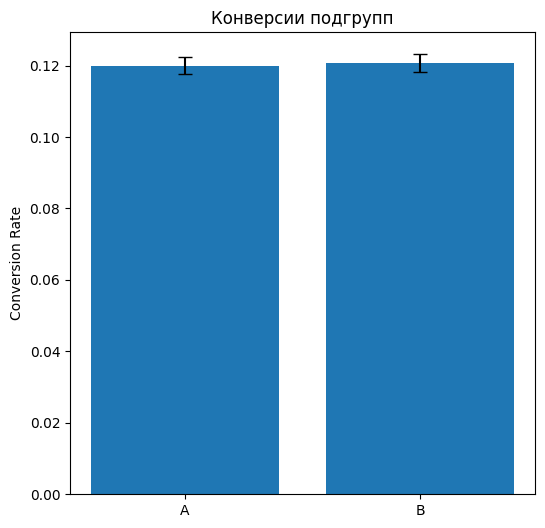

In [21]:
#проверка аа теста только на контрольной группу
control = df[df['group'] == 'control'].copy()
np.random.seed(42)
control['subgroup'] = np.random.choice(['A', 'B'], size=len(control))

# доеврительный интервал
def simple_ci(conv, n, alpha=0.05):
    p = conv / n
    z = norm.ppf(1 - alpha/2)
    se = np.sqrt(p * (1 - p) / n)
    return p - z*se, p + z*se

results = []
#проверяем однородность контрольной группы по подгруппам
for name, g in control.groupby('subgroup'):
    conv = g['converted'].sum()
    n = len(g)
    p = conv / n
    low, high = simple_ci(conv, n)
    results.append([name, p, low, high, n])
aa = pd.DataFrame(results, columns=['subgroup','cr','ci_low','ci_high','count'])
print(aa)

plt.figure(figsize=(6,6))
plt.bar(aa['subgroup'], aa['cr'],
        yerr=[aa['cr'] - aa['ci_low'], aa['ci_high'] - aa['cr']],
        capsize=5)
plt.ylabel("Conversion Rate")
plt.title("Конверсии подгрупп")
plt.show()


# Гипотезы

На основании выбранной метрики наша команда выдвигает следующие гипотезы:

**Нулевая гипотеза (H₀)** - конверсия в группе treatment не отличается от конверсии в группе control.

**Альтернативная гипотеза (H₁)** - конверсия в группе treatment отличается от конверсии в группе control.

# Выбор статистического теста

Для сравнения конверсии между двумя группами в A/B-тесте оптимальным выбором является Z-тест для двух пропорций, так как мы работаем с бинарной метрикой (конвертировался/не конвертировался), имеем две независимые выборки (control и treatment) и достаточно большой объём данных для нормальной аппроксимации выборочного распределения долей согласно ЦПТ. Этот тест отвечает на вопрос о статистической значимости различий в конверсиях, позволяет рассчитать разность пропорций и её доверительный интервал, что очень важно для оценки практической значимости эффекта, и является стандартным инструментом для решения подобных задач. Альтернативы, такие как точный тест Фишера, избыточны для больших выборок, а хи-квадрат, хотя и применим, не предоставляет такой же удобной интерпретации в контексте A/B-тестирования.

**Основные условия для применения Z-теста:**

Правило "np ≥ 5 и n(1-p) ≥ 5" для каждой группы:

In [22]:
control = df[df['group'] == 'control']
treatment = df[df['group'] == 'treatment']

n_control = len(control)
n_treatment = len(treatment)

p_control = control['converted'].mean()
p_treatment = treatment['converted'].mean()

# Проверяем условия
conditions = {
    'control_np': n_control * p_control,
    'control_nq': n_control * (1 - p_control),
    'treatment_np': n_treatment * p_treatment,
    'treatment_nq': n_treatment * (1 - p_treatment)
}

print("Проверка условий для нормальной аппроксимации:")
for name, value in conditions.items():
    status = "OK" if value >= 5 else "Не OK"
    print(f"{name}: {value:.1f} {status}")

Проверка условий для нормальной аппроксимации:
control_np: 16687.0 OK
control_nq: 121974.0 OK
treatment_np: 16474.0 OK
treatment_nq: 122302.0 OK


Минимальный размер выборки:

Каждая группа должна содержать не менее 30 наблюдений
В идеале — не менее 100 наблюдений для хорошей аппроксимации

# Установка значений параметров

**Уровень значимости (α) = 0.05** - данный параметр означает готовность в 5% случаев ошибочно отклонить нулевую гипотезу. Это является стандартным значением, мы решили использовать его, тк тестируем изменения в лендинге, а не в критически важных сферах.


При обосновании выбора MDE мы столкнулись с трудностями из-за ограниченности данных: у нас нет точной информации о том, насколько масштабными были изменения на новой странице и какие ресурсы на них затрачены.

Предположим, что изменения относятся к средней категории по степени вмешательства: они модифицируют ключевые компоненты страницы, влияющие на восприятие ценности и юзабилити, но не меняют фундаментальное ядро предложения.
Baseline-конверсия составляет 12.04%, причём конверсией считается регистрация на курс (сфера образования), что является высоким показателем.
Поэтому установим **минимальный детектируемый эффект = 1 процентный пункт.**

# Z-тест

In [23]:
# Z-тест на всех данных
s_c = df[df['group']=='control']['converted'].sum()
s_t = df[df['group']=='treatment']['converted'].sum()
n_c = len(df[df['group']=='control'])
n_t = len(df[df['group']=='treatment'])
z_all, p_all = proportions_ztest([s_c, s_t], [n_c, n_t])
print("\nZ-тест на всех данных: Z =", round(z_all, 4), "p =", round(p_all, 5))


Z-тест на всех данных: Z = 1.327 p = 0.18451


In [24]:
#конверсия по группам
cr_control = df[df['group']=='control']['converted'].mean()
cr_treatment = df[df['group']=='treatment']['converted'].mean()

# uplift
uplift = cr_treatment - cr_control

print(f"CR control: {cr_control:.4%}")
print(f"CR treatment: {cr_treatment:.4%}")
print(f"uplift: {uplift:.4}")

CR control: 12.0344%
CR treatment: 11.8709%
uplift: -0.001635


(Р-value = 0.18451) ≥ (α = 0.05). Это означает, что нет достаточных статистических доказательств, чтобы отвергнуть нулевую гипотезу об отсутствии разницы в конверсии между группами treatment и control.

Даже если бы наблюдаемый эффект был статистически значимым, uplift = -0.1635 п.п. существенно меньше MDE = 1 п.п. Таким образом, изменение не достигает минимального уровня, который был бы признан бизнес-значимым для его внедрения.

# Bootstrap-анализ

In [25]:
control = df[df['group'] == 'control']['converted']
treat = df[df['group'] == 'treatment']['converted']

# Оценки на оригинальных данных
mean_control = control.mean()
mean_treat = treat.mean()
obs_diff = mean_treat - mean_control   # наблюдаемая разница

print("Оригинальные данные:")
print(f"Control mean = {mean_control:.4f}")
print(f"Treatment mean = {mean_treat:.4f}")
print(f"Разница (treat - control) = {obs_diff:.5f}")

# Bootstrap
N_BOOT = 10000
boot_diffs = []

for _ in range(N_BOOT):
    sample_control = np.random.choice(control, size=len(control), replace=True)
    sample_treat = np.random.choice(treat, size=len(treat), replace=True)

    boot_diffs.append(sample_treat.mean() - sample_control.mean())

boot_diffs = np.array(boot_diffs)

# 95% доверительный интервал
ci_low = np.percentile(boot_diffs, 2.5)
ci_high = np.percentile(boot_diffs, 97.5)

print("\nBootstrap 95% CI для разницы конверсий:")
print(f"({ci_low:.5f}, {ci_high:.5f})")

# p-value bootstrap (двусторонний тест)
p_value = (np.abs(boot_diffs) >= abs(obs_diff)).mean()
print(f"\nBootstrap p-value = {p_value:.4f}")

Оригинальные данные:
Control mean = 0.1203
Treatment mean = 0.1187
Разница (treat - control) = -0.00163

Bootstrap 95% CI для разницы конверсий:
(-0.00408, 0.00077)

Bootstrap p-value = 0.4965


Мы провели дополнительный анализ методом bootstrap, чтобы проверить результаты Z-теста на устойчивость и оценить реальную разницу конверсий между группами без допущений о распределении данных.

Результаты bootstrap показали:

	•	Средняя конверсия control = 0.1203, treatment = 0.1187. Разница (treat − control) = −0.16%.
	•	95% доверительный интервал для разницы конверсий: (-0.00404, 0.00078).
	•	Bootstrap p-value = 0.498 — статистически значимой разницы нет.

**Вывод:** новая версия лендинга не меняет конверсию по сравнению с текущей. Разница очень маленькая и не имеет практической значимости, подтверждая результаты Z-теста. Этот анализ показал, что результаты эксперимента стабильны и не зависят от случайных колебаний данных.

# Рекомендации для бизнеса

Рекомендации для бизнеса

Не внедрять новую страницу глобально, поскольку эксперимент показал отсутствие значимого улучшения. Также стоит сфокусироваться на улучшении элементов старой страницы, которые действительно влияют на конверсию: тексты, кнопки, оформление, CTA

Бизнес-инсайты

Стабильность CR в контрольной группе показывает, что текущая страница работает нормально.
Новые элементы страницы не увеличивают конверсию  возможно пользователи не замечают изменений или они не релевантны.